In [6]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp
from sklearn.model_selection import StratifiedKFold
from efficientnet_pytorch import EfficientNet
from cvcore.data.auto_augment import RandAugment
from PIL import Image
from utils import bn_update, moving_average, copy_model


In [7]:
!ls /home/chec/data/bengali

ls: cannot access '/home/chec/data/bengali': No such file or directory


In [8]:
#!ls /home/chec/data/bengali

In [9]:
DATA_DIR = '/mnt/chicm/data/bengali'

In [10]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [11]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [64]:
train_df.grapheme_root.unique()

array([ 15, 159,  22,  53,  71, 153,  52, 139,  67,  64, 115, 107,  74,
       100,  48,  72,  13,  79, 109,  23,  42,  60, 142,  61, 147,  81,
       148, 160,  58,  99, 103,  44, 167, 120,  62, 151,  32, 125,  38,
       127,  24, 124,  96,  43, 132, 149, 123,  54,  19,  87,  35,  83,
        97,  77, 165,  92, 133, 118,  85,  56,  95, 136, 138, 106,  86,
        29,  39, 122,  65,  30,  76,  16,  68, 110,  46, 105, 155, 129,
        25,  59,  36,  70, 152,  18,  89, 128, 113, 144,  49, 117, 154,
        31,   6,  26, 150,  40, 111,  55,   1, 119, 140,  66,  28,  14,
       164,  27, 121, 156,  63,  84, 137,  98, 143,  47, 135,  75, 141,
        88, 116,  91,  45,  69,  94,  93, 131, 146, 134, 112, 108,   9,
        80,   3, 166,  41,  17, 162,  21, 158,  10,  51, 101,  82,  57,
         4,   5,  90,  20,   2, 102, 126,  33, 161,  34,  50,   7, 163,
        78,  73, 145, 130,   0, 104,   8,  37,  11, 157, 114,  12])

In [118]:
class_map_df

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [12]:
HEIGHT = 137
WIDTH = 236

In [13]:
#import albumentations as albu
def get_train_augs():
    return RandAugment(n=2, m=27)

In [14]:
#plt.imshow(x)

In [15]:
#np.arange(10).copy()

In [126]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


class BengaliDataset(Dataset):
    def __init__(self, df, img_df, train_mode=True, test_mode=False):
        self.df = df
        self.img_df = img_df
        self.train_mode = train_mode
        self.test_mode = test_mode

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = self.get_img(row.image_id)
        orig_img = img.copy()
        #print(img.shape)
        if self.train_mode:
            augs = get_train_augs()
            #img = augs(image=img)['image']
            img = np.asarray(augs(Image.fromarray(img)))
        
        img = np.expand_dims(img, axis=-1)
        orig_img = np.expand_dims(orig_img, axis=-1)
        
        #print('###', img.shape)
        #img = np.concatenate([img, img, img], 2)
        #print('>>>', img.shape)
        
        # taken from https://www.kaggle.com/iafoss/image-preprocessing-128x128
        #MEAN = [ 0.06922848809290576,  0.06922848809290576,  0.06922848809290576]
        #STD = [ 0.20515700083327537,  0.20515700083327537,  0.20515700083327537]
        
        img = transforms.functional.to_tensor(img)
        orig_img = transforms.functional.to_tensor(orig_img)
        
        #img = transforms.functional.normalize(img, mean=MEAN, std=STD)
        
        if self.test_mode:
            return img
        elif self.train_mode:
            return img, orig_img, torch.tensor([row.grapheme_root, row.vowel_diacritic, row.consonant_diacritic, row.word_label])
        else:
            return img, torch.tensor([row.grapheme_root, row.vowel_diacritic, row.consonant_diacritic, row.word_label])
                    
    def get_img(self, img_id):
        return 255 - self.img_df.loc[img_id].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

    def __len__(self):
        return len(self.df)
    
def get_train_val_loaders(batch_size=4, val_batch_size=4, ifold=0, dev_mode=False):
    train_df = pd.read_csv(f'{DATA_DIR}/train.csv')

    train_df = shuffle(train_df, random_state=1234)

    grapheme_words = np.unique(train_df.grapheme.values)
    grapheme_words_dict = {grapheme: i for i, grapheme in enumerate(grapheme_words)}
    train_df['word_label'] = train_df['grapheme'].map(lambda x: grapheme_words_dict[x])

    print(train_df.shape)

    if dev_mode:
        img_df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet').set_index('image_id')
        train_df = train_df.iloc[:1000]
    else:
        img_dfs = [pd.read_parquet(f'{DATA_DIR}/train_image_data_{i}.parquet') for i in range(4)]
        img_df = pd.concat(img_dfs, axis=0).set_index('image_id')
    print(img_df.shape)
    #split_index = int(len(train_df) * 0.9)
    
    #train = train_df.iloc[:split_index]
    #val = train_df.iloc[split_index:]
    
    kf = StratifiedKFold(5, random_state=1234, shuffle=True)
    for i, (train_idx, val_idx) in enumerate(kf.split(train_df, train_df['grapheme_root'].values)):
        if i == ifold:
            #print(val_idx)
            train = train_df.iloc[train_idx]
            val = train_df.iloc[val_idx]
            break
    assert i == ifold
    print(train.shape, val.shape)
    
    train_ds = BengaliDataset(train, img_df, True, False)
    val_ds = BengaliDataset(val, img_df, False, False)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
    train_loader.num = len(train_ds)

    val_loader = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False, num_workers=8, drop_last=False)
    val_loader.num = len(val_ds)
    val_loader.df = val

    return train_loader, val_loader

In [17]:
#train_loader, val_loader = get_train_val_loaders()

In [18]:
#for x in train_loader:
#    print(x)
#    break

# model

In [19]:
#import pretrainedmodels

In [20]:
#model_name = 'resnet50' # could be fbresnet152 or inceptionresnetv2
#model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet').cuda()
#model.eval()

In [21]:
from argparse import Namespace
import timm
from timm.models.activations import Swish, Mish
from timm.models.adaptive_avgmax_pool import SelectAdaptivePool2d

In [22]:
MEAN = [ 0.06922848809290576 ]
STD = [ 0.20515700083327537 ]

In [23]:
MEAN = [ 0.06922848809290576 ]
STD = [ 0.20515700083327537 ]
import timm
from timm.models.activations import Swish, Mish
from timm.models.adaptive_avgmax_pool import SelectAdaptivePool2d

class BengaliNet4(nn.Module):
    def __init__(self, backbone_name='se_resnext50_32x4d'):
        super(BengaliNet4, self).__init__()
        self.n_grapheme = 168
        self.n_vowel = 11
        self.n_consonant = 7
        self.n_word = 1295
        self.backbone_name = backbone_name
        
        self.num_classes = self.n_grapheme + self.n_vowel + self.n_consonant + self.n_word
        
        self.backbone = pretrainedmodels.__dict__[self.backbone_name](num_classes=1000, pretrained='imagenet')
        self.fc = nn.Linear(self.backbone.last_linear.in_features, self.num_classes)
        
        self.num_p2_features = self.backbone.layer2[-1].se_module.fc2.out_channels
        self.num_p3_features = self.backbone.layer3[-1].se_module.fc2.out_channels
        self.p2_head = nn.Conv2d(self.num_p2_features, self.num_p2_features * 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.p3_head = nn.Conv2d(self.num_p3_features, self.num_p3_features * 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(self.num_p2_features * 4)
        self.bn3 = nn.BatchNorm2d(self.num_p3_features * 4)
        self.act2 = Swish()
        self.act3 = Swish()
        
        self.fc_aux1 = nn.Linear(self.num_p3_features * 4, self.num_classes)
        self.fc_aux2 = nn.Linear(self.num_p2_features * 4, self.num_classes)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        for fc in [self.fc, self.fc_aux1, self.fc_aux2]:
            nn.init.zeros_(fc.bias.data)

        print('init model4')
        
    def features(self, x):
        x = self.backbone.layer0(x); #print(x.size())
        x = self.backbone.layer1(x); #print(x.size())
        x = self.backbone.layer2(x); p2 = x; p2 = self.p2_head(p2); p2 = self.bn2(p2); p2 = self.act2(p2) #print(x.size())
        x = self.backbone.layer3(x); p3 = x; p3 = self.p3_head(p3); p3 = self.bn3(p3); p3 = self.act3(p3) #print(x.size())
        x = self.backbone.layer4(x); #print(x.size())
        return x, p2, p3
        
    def logits(self, x, p2, p3):
        x = self.avg_pool(x)
        #x = F.dropout2d(x, 0.2, self.training)
        x = torch.flatten(x, 1)
        
        p2 = self.avg_pool(p2)
        p2 = torch.flatten(p2, 1)
        
        p3 = self.avg_pool(p3)
        p3 = torch.flatten(p3, 1)
        return self.fc(x), self.fc_aux1(p3), self.fc_aux2(p2)
    
    def forward(self, x):
        x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)
        for i in range(len(x)):
            transforms.functional.normalize(x[i], mean=MEAN, std=STD, inplace=True)
        x = torch.cat([x,x,x], 1)
        #x = self.conv0(x)
        #print(x.size())
        x, p2, p3 = self.features(x)
        x, logits_aux1, logits_aux2 = self.logits(x, p2, p3)

        return x, logits_aux1, logits_aux2

In [24]:
MODEL_DIR = './model4-ckps'
def create_model(args):
    model = BengaliNet4(args.backbone)
    model_file = os.path.join(MODEL_DIR, args.backbone, args.ckp_name)

    parent_dir = os.path.dirname(model_file)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)

    print('model file: {}, exist: {}'.format(model_file, os.path.exists(model_file)))

    if os.path.exists(model_file):
        print('loading {}...'.format(model_file))
        model.load_state_dict(torch.load(model_file))
    
    return model, model_file

In [25]:
#bnet = BengaliNet('se_resnext50_32x4d').cuda()

In [26]:
#bnet(torch.randn((2, 1, 137, 236)).cuda()).size()

# train

In [81]:
a = np.array([1,1,2,2,3,4,2])
idx = np.where(a!=2)

In [107]:
idx[0]

array([0, 1, 4, 5])

In [111]:
a[idx[0]]

array([1, 1, 3, 4])

In [61]:
from sklearn.metrics import recall_score, accuracy_score
y_true = [2, 2, 2, 2, 2]
y_pred = [2, 2, 12, 2, 2]
accuracy_score(y_true, y_pred)

0.8

In [112]:
import numpy as np
import sklearn.metrics
import torch

def get_grapheme_class_acc(preds, y):
    metrics = {}
    for c in range(168):
        idx = np.where(y==c)[0]
        cls_pred = preds[idx]
        y_true = y[idx]
        acc = sklearn.metrics.accuracy_score(y_true, cls_pred)
        
        if acc == 1:
            continue
        
        cls_metrics = {}
        cls_metrics['acc'] = round(acc, 6)
        cls_metrics['total'] = len(y_true)
        #cls_metrics['y_true'] = y_true
        cls_metrics['wrong_preds'] = cls_pred[np.where(cls_pred!=c)]
        cls_metrics['wrong_img_idx'] = idx[np.where(cls_pred!=c)]
        
        metrics[c] = cls_metrics
    return metrics

def calc_metrics(preds0, preds1, preds2, preds3, y):
    assert len(y) == len(preds0) == len(preds1) == len(preds2) == len(preds3)

    recall_grapheme = sklearn.metrics.recall_score(preds0, y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(preds1, y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(preds2, y[:, 2], average='macro')
    recall_word = sklearn.metrics.recall_score(preds3, y[:, 3], average='macro')
    
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_recall_score = np.average(scores, weights=[2, 1, 1])
    
    metrics = {}
    metrics['recall'] = round(final_recall_score, 6)
    metrics['recall_grapheme'] = round(recall_grapheme, 6)
    metrics['recall_vowel'] = round(recall_vowel, 6)
    metrics['recall_consonant'] = round(recall_consonant, 6)
    metrics['recall_word'] = round(recall_word, 6)
    
    metrics['acc_grapheme'] = round((preds0 == y[:, 0]).sum() / len(y), 6)
    metrics['acc_vowel'] = round((preds1 == y[:, 1]).sum() / len(y), 6)
    metrics['acc_consonant'] = round((preds2 == y[:, 2]).sum() / len(y), 6)
    metrics['acc_word'] = round((preds3 == y[:, 3]).sum() / len(y), 6)   
    
    metrics['grapheme_cls_acc'] = get_grapheme_class_acc(preds0, y[:, 0])
    
    return metrics

In [29]:
def criterion(outputs, y_true):
    # outputs: (N, 182)
    # y_true: (N, 3)
    
    outputs = torch.split(outputs, [168, 11, 7, 1295], dim=1)
    loss0 = F.cross_entropy(outputs[0], y_true[:, 0], reduction='mean')
    loss1 = F.cross_entropy(outputs[1], y_true[:, 1], reduction='mean')
    loss2 = F.cross_entropy(outputs[2], y_true[:, 2], reduction='mean')
    loss3 = F.cross_entropy(outputs[3], y_true[:, 3], reduction='mean')
    
    return loss0 + loss1 + loss2 + loss3 #, loss0.item(), loss1.item(), loss2.item()
    #return loss3

In [30]:
def validate(model, val_loader):
    model.eval()
    loss0, loss1, loss2, loss3 = 0., 0., 0., 0.
    preds0, preds1, preds2, preds3 = [], [], [], []
    y_true = []
    with torch.no_grad():
        for x, y in val_loader:
            y_true.append(y)
            x, y = x.cuda(), y.cuda()
            outputs, outputs_aux1, outputs_aux2 = model(x)
            #avg_outputs = torch.mean(torch.stack([outputs, outputs_aux1, outputs_aux2], 0), 0)
            outputs = torch.split(outputs, [168, 11, 7, 1295], dim=1)
            
            preds0.append(torch.max(outputs[0], dim=1)[1])
            preds1.append(torch.max(outputs[1], dim=1)[1])
            preds2.append(torch.max(outputs[2], dim=1)[1])
            preds3.append(torch.max(outputs[3], dim=1)[1])
            loss0 += F.cross_entropy(outputs[0], y[:, 0], reduction='sum').item()
            loss1 += F.cross_entropy(outputs[1], y[:, 1], reduction='sum').item()
            loss2 += F.cross_entropy(outputs[2], y[:, 2], reduction='sum').item()
            loss3 += F.cross_entropy(outputs[3], y[:, 3], reduction='sum').item()
            
            # for debug
            #metrics = {}
            #metrics['loss_grapheme'] =  F.cross_entropy(outputs[0], y[:, 0], reduction='mean').item()
            #metrics['loss_vowel'] =  F.cross_entropy(outputs[1], y[:, 1], reduction='mean').item()
            #metrics['loss_consonant'] =  F.cross_entropy(outputs[2], y[:, 2], reduction='mean').item()
            #return metrics
    
    preds0 = torch.cat(preds0, 0).cpu().numpy()
    preds1 = torch.cat(preds1, 0).cpu().numpy()
    preds2 = torch.cat(preds2, 0).cpu().numpy()
    preds3 = torch.cat(preds3, 0).cpu().numpy()
    
    y_true = torch.cat(y_true, 0).numpy()
    
    #print('y_true:', y_true.shape)
    #print('preds0:', preds0.shape)
    
    metrics = calc_metrics(preds0, preds1, preds2, preds3, y_true)
    metrics['loss_grapheme'] = round(loss0 / val_loader.num, 6)
    metrics['loss_vowel'] = round(loss1 / val_loader.num, 6)
    metrics['loss_consonant'] = round(loss2 / val_loader.num, 6)
    metrics['loss_word'] = round(loss3 / val_loader.num, 6)
    
    return metrics
            

In [40]:
args = Namespace()
args.backbone = 'se_resnext50_32x4d'
args.ckp_name = 'model4_se_resnext50_fold0_224_cv998106.pth'

args.base_lr = 8e-5
args.num_epochs = 80
args.start_epoch = 19
args.warmup_epochs = 5

args.num_cycles = 100
args.batch_size = 640
args.val_batch_size = 1024
args.st_epochs = 10

args.swa_start = 20
args.swa_freq = 2

args.beta = 1.0
args.cutmix_prob = 0.5

In [127]:
train_loader, val_loader = get_train_val_loaders(batch_size=args.batch_size, val_batch_size=args.val_batch_size, ifold=0)

(200840, 6)
(200840, 32332)
(160596, 6) (40244, 6)


In [43]:
#for param in model.backbone.parameters():
#    param.requires_grad = False
model, _ = create_model(args)
model = model.cuda()
model = amp.initialize(model, None, opt_level='O1', verbosity=0)
model = nn.DataParallel(model)

init model4
model file: ./model4-ckps/se_resnext50_32x4d/model4_se_resnext50_fold0_224_cv998106.pth, exist: True
loading ./model4-ckps/se_resnext50_32x4d/model4_se_resnext50_fold0_224_cv998106.pth...


In [94]:
val_imgs, val_targets = [], []

In [95]:
from tqdm import tqdm
for img, target in tqdm(val_loader):
    val_imgs.append(img)
    val_targets.append(target)
    
val_imgs = torch.cat(val_imgs, 0)
val_targets = torch.cat(val_targets, 0).numpy()

100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


In [104]:
from torchvision import transforms

def show_imgs(img_idxs, titles=None):
    imgs = [transforms.functional.to_pil_image(val_imgs[i]) for i in img_idxs]
    n = len(imgs)
    plt.figure(figsize=(30, 20))
    columns = 4
    for i, img in enumerate(imgs):
        plt.subplot(n / columns + 1, columns, i + 1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img)

In [145]:
def show_imgs_by_type(root):
    val_df = val_loader.df.reset_index().reset_index()
    idx = val_df[val_df.grapheme_root==root].sample(8).level_0.values
    show_imgs(idx)

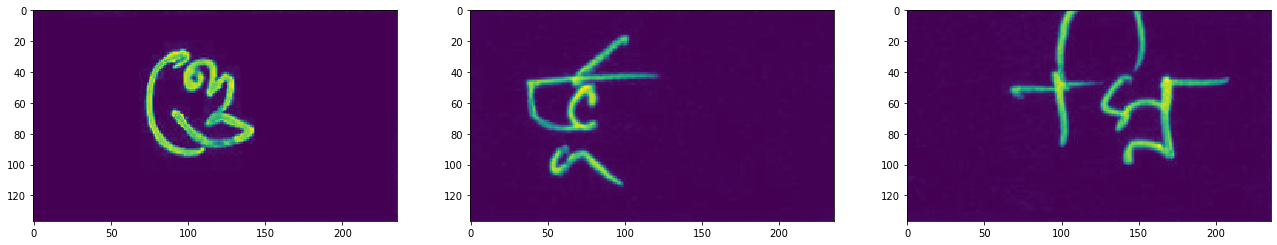

In [105]:
show_imgs([0, 1, 200])

In [113]:
metrics = validate(model, val_loader)

In [114]:
metrics

{'recall': 0.998112,
 'recall_grapheme': 0.997877,
 'recall_vowel': 0.998548,
 'recall_consonant': 0.998147,
 'recall_word': 0.997093,
 'acc_grapheme': 0.997391,
 'acc_vowel': 0.998708,
 'acc_consonant': 0.998807,
 'acc_word': 0.997217,
 'grapheme_cls_acc': {9: {'acc': 0.988764,
   'total': 89,
   'wrong_preds': array([13]),
   'wrong_img_idx': array([34624])},
  13: {'acc': 0.999077,
   'total': 1084,
   'wrong_preds': array([16]),
   'wrong_img_idx': array([19439])},
  18: {'acc': 0.993884,
   'total': 327,
   'wrong_preds': array([159, 115]),
   'wrong_img_idx': array([17235, 21076])},
  19: {'acc': 0.982143,
   'total': 56,
   'wrong_preds': array([120]),
   'wrong_img_idx': array([13842])},
  20: {'acc': 0.985294,
   'total': 68,
   'wrong_preds': array([138]),
   'wrong_img_idx': array([3490])},
  22: {'acc': 0.996627,
   'total': 593,
   'wrong_preds': array([ 71, 103]),
   'wrong_img_idx': array([19118, 32561])},
  23: {'acc': 0.996117,
   'total': 1030,
   'wrong_preds': array

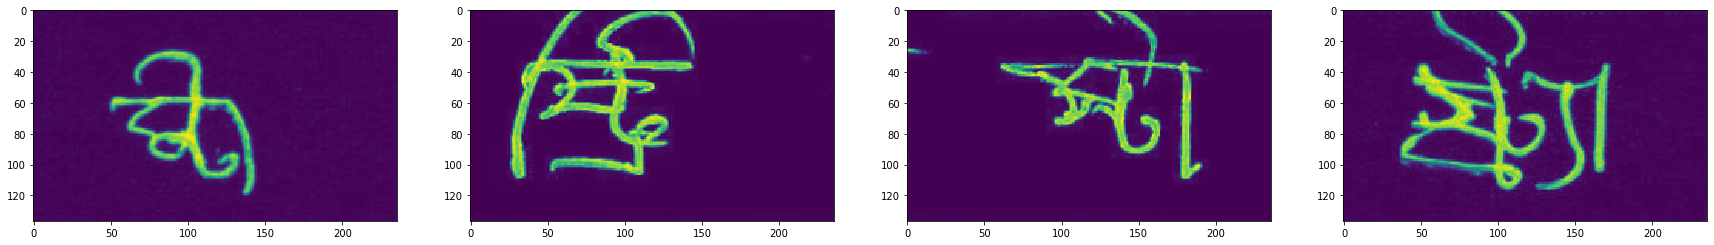

In [115]:
show_imgs([9411, 19974, 24280, 30605])

In [124]:
class_map_df[(class_map_df.component_type=='grapheme_root') & (class_map_df.label==149)].component

149    স্ট
Name: component, dtype: object

In [125]:
class_map_df[(class_map_df.component_type=='grapheme_root') & (class_map_df.label==141)].component

141    ষ্ট
Name: component, dtype: object

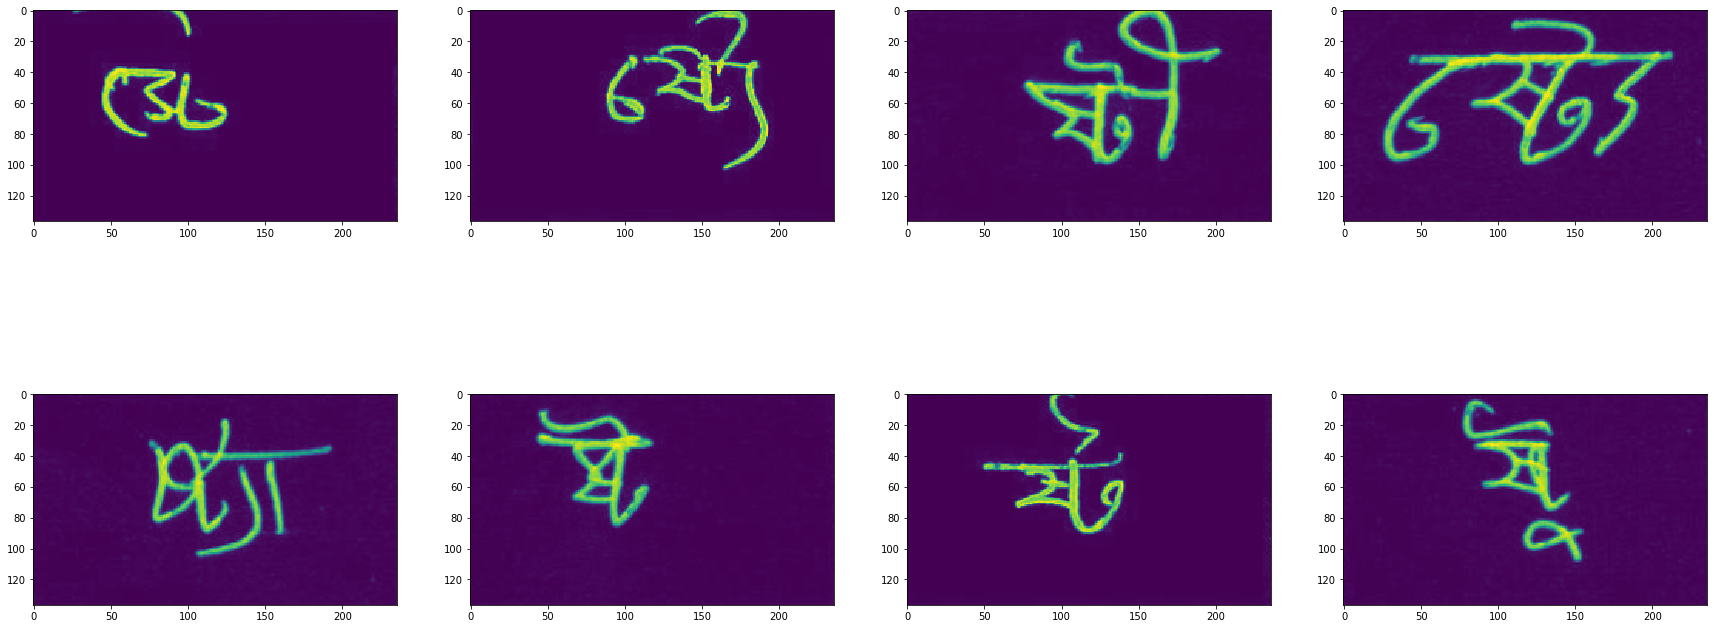

In [152]:
show_imgs_by_type(141)

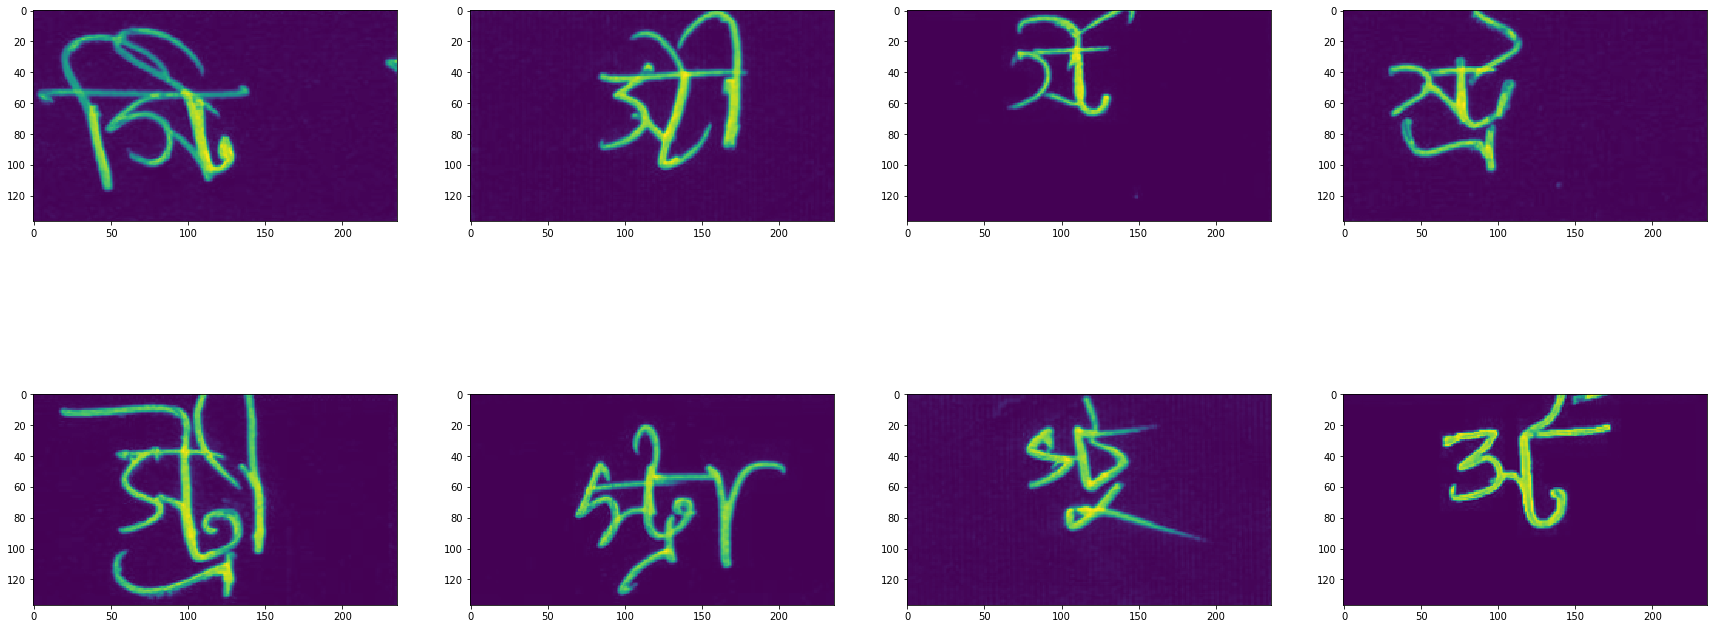

In [153]:
show_imgs_by_type(149)